# Clustering

Clustering techniques are unsupervised learning algorithms that try to group unlabelled data into "clusters", using the (typically spatial) structure of the data itself. It has many [applications](https://en.wikipedia.org/wiki/Cluster_analysis#Applications).

The easiest way to demonstrate how clustering works is to simply generate some data and show them in action. We'll start off by importing the libraries we'll be using today.

In [8]:
import math, matplotlib.pyplot as plt, operator, torch
from functools import partial

In [9]:
torch.manual_seed(42)
torch.set_printoptions(precision=3, linewidth=140, sci_mode=False)

## Create data

In [10]:
n_clusters=6
n_samples =250

To generate our data, we're going to pick 6 random points, which we'll call centroids, and for each point we're going to generate 250 random points about it.

In [11]:
# middle of the clusters
centroids = torch.rand(n_clusters, 2)*70-35

In [12]:
centroids

tensor([[ 26.759,  29.050],
        [ -8.200,  32.151],
        [ -7.669,   7.063],
        [-17.040,  20.555],
        [ 30.854, -25.677],
        [ 30.422,   6.551]])

In [13]:
from torch.distributions.multivariate_normal import MultivariateNormal
from torch import tensor

*NOTE:* multivariate same is normal, but you pass to means for multivariate std normal there isnt same number of std deviations as the means.
The variables (x and y here), migth not be independent from each other they might covariate. Hence it accepts a covariance matrix. Lesson 9b this is more discussed. 

In [14]:
def sample(m): return MultivariateNormal(m, torch.diag(tensor([5.,5.]))).sample((n_samples,))

In [15]:
slices = [sample(c) for c in centroids]
data = torch.cat(slices)
data.shape

torch.Size([1500, 2])

In [16]:
data

tensor([[26.204, 26.349],
        [25.691, 30.213],
        [30.431, 28.693],
        ...,
        [30.772,  9.323],
        [29.354,  3.960],
        [31.168,  5.309]])

Below we can see each centroid marked w/ X, and the coloring associated to each respective cluster.

In [10]:
def plot_data(centroids, data, n_samples, ax=None):
    if ax is None: _,ax = plt.subplots()
    for i, centroid in enumerate(centroids):
        samples = data[i*n_samples:(i+1)*n_samples]
        ax.scatter(samples[:,0], samples[:,1], s=1)
        ax.plot(*centroid, markersize=10, marker="x", color='k', mew=5)
        ax.plot(*centroid, markersize=5, marker="x", color='m', mew=2)

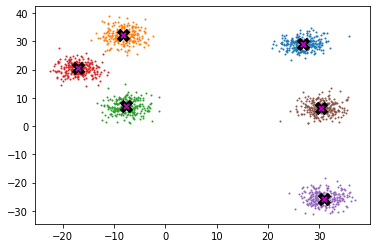

In [11]:
plot_data(centroids, data, n_samples)

## Mean shift

Most people that have come across clustering algorithms have learnt about **k-means**. Mean shift clustering is a newer and less well-known approach, but it has some important advantages:
* It doesn't require selecting the number of clusters in advance, but instead just requires a **bandwidth** to be specified, which can be easily chosen automatically
* It can handle clusters of any shape, whereas k-means (without using special extensions) requires that clusters be roughly ball shaped.

The algorithm is as follows:
* For each data point x in the sample X, find the distance between that point x and every other point in X
* Create weights for each point in X by using the **Gaussian kernel** of that point's distance to x
    * This weighting approach penalizes points further away from x
    * The rate at which the weights fall to zero is determined by the **bandwidth**, which is the standard deviation of the Gaussian
* Update x as the weighted average of all other points in X, weighted based on the previous step

This will iteratively push points that are close together even closer until they are next to each other.

In [12]:
midp = data.mean(0)
midp

tensor([ 9.222, 11.604])

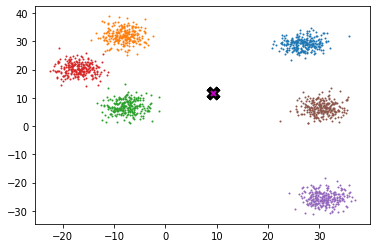

In [13]:
plot_data([midp]*6, data, n_samples)

So here's the definition of the gaussian kernel, which you may remember from high school...
 This person at the science march certainly remembered!

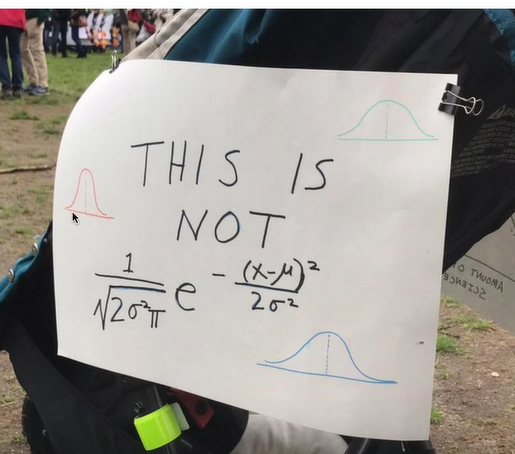

In [14]:
def gaussian(d, bw): return torch.exp(-0.5*((d/bw))**2) / (bw*math.sqrt(2*math.pi))

In [15]:
def plot_func(f):
    x = torch.linspace(0,10,100)
    plt.plot(x, f(x))

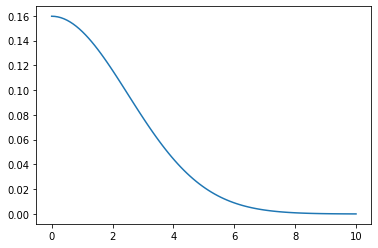

In [16]:
plot_func(partial(gaussian, bw=2.5))

In [17]:
partial?

Init signature: partial(self, /, *args, **kwargs)
Docstring:     
partial(func, *args, **keywords) - new function with partial application
of the given arguments and keywords.
File:           /usr/lib/python3.9/functools.py
Type:           type
Subclasses:     


In our implementation, we choose the bandwidth to be 2.5. 
**One easy way to choose bandwidth is to find which bandwidth covers one third of the data.**

In [18]:
# another way of weighting tha is easier
def tri(d, i): return (-d+i).clamp_min(0)/i

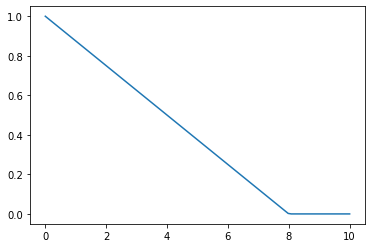

In [19]:
plot_func(partial(tri, i=8))

In [20]:
X = data.clone()
x = data[0]
x

tensor([26.204, 26.349])

In [21]:
x.shape,X.shape,x[None].shape

(torch.Size([2]), torch.Size([1500, 2]), torch.Size([1, 2]))

In [22]:
# test for the diff subtraction
(x[None]-X)[:8]

tensor([[ 0.000,  0.000],
        [ 0.513, -3.865],
        [-4.227, -2.345],
        [ 0.557, -3.685],
        [-5.033, -3.745],
        [-4.073, -0.638],
        [-3.415, -5.601],
        [-1.920, -5.686]])

In [23]:
(x-X)[:8] # it broadcasts, it pretends there's a unit axis x[None]

tensor([[ 0.000,  0.000],
        [ 0.513, -3.865],
        [-4.227, -2.345],
        [ 0.557, -3.685],
        [-5.033, -3.745],
        [-4.073, -0.638],
        [-3.415, -5.601],
        [-1.920, -5.686]])

In [24]:

dist = ((x-X)**2).sum(1).sqrt() # eucl distance
dist[:8]

tensor([0.000, 3.899, 4.834, 3.726, 6.273, 4.122, 6.560, 6.002])

In [25]:
# rewrite using torch.einsum
diff = (x-X)
# i -> 1500
# k -> 2
es = torch.einsum('ik,ki->i', diff, diff.T).sqrt()
es[:8]

tensor([0.000, 3.899, 4.834, 3.726, 6.273, 4.122, 6.560, 6.002])

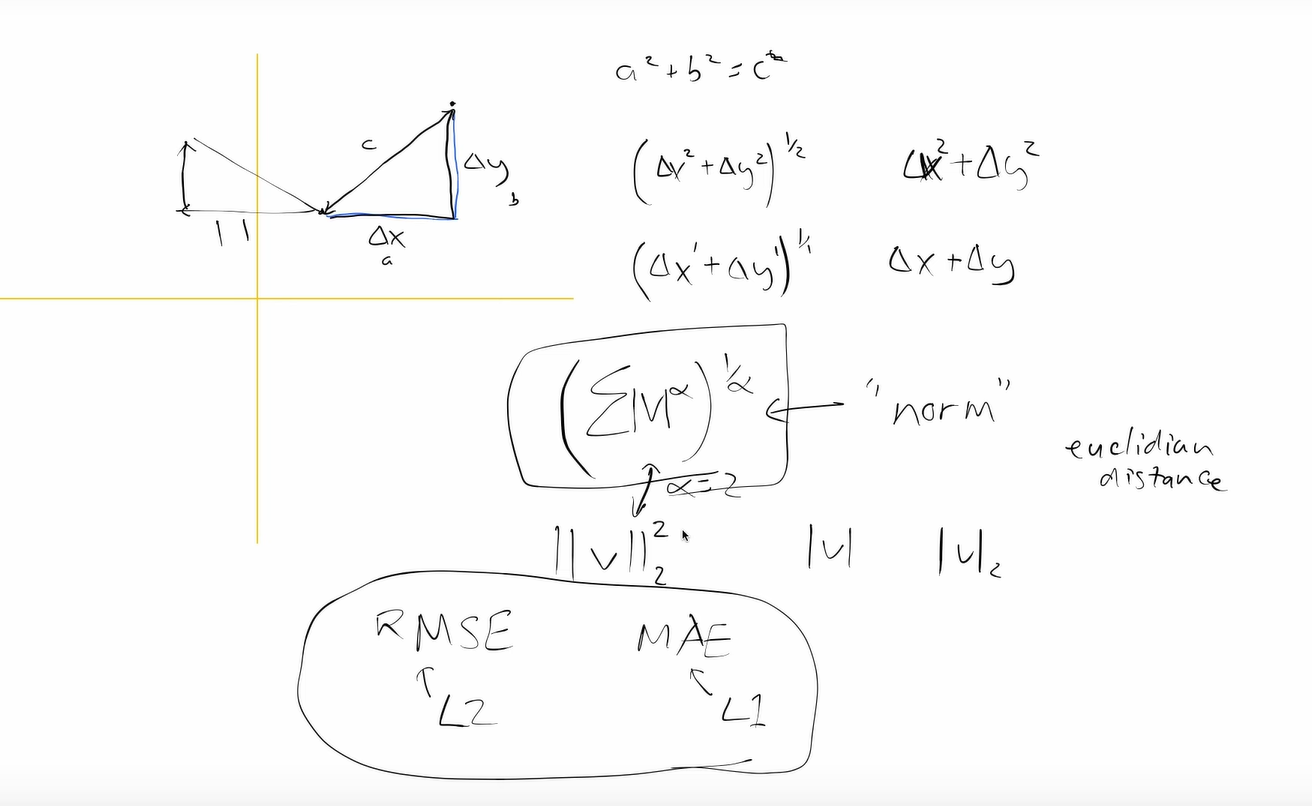

In [26]:
weight = gaussian(dist, 2.5)
weight

tensor([    0.160,     0.047,     0.025,  ...,     0.000,     0.000,     0.000])

In [27]:
weight.shape,X.shape

(torch.Size([1500]), torch.Size([1500, 2]))

In [28]:
weight[:,None].shape

torch.Size([1500, 1])

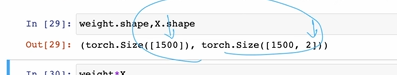

In [29]:
weight.shape, X.shape

(torch.Size([1500]), torch.Size([1500, 2]))

In [30]:
# from right to left, 2 is not compatible with 1500
# things are compatible if they are equal or one is at least 1
# need to add a dim to weight at axis 1 
weight * X

RuntimeError: The size of tensor a (1500) must match the size of tensor b (2) at non-singleton dimension 1

In [31]:
# dim 1 boradcasts to the 2
weight[:,None].shape, X.shape

(torch.Size([1500, 1]), torch.Size([1500, 2]))

In [32]:
# weighted average
weight[:,None]*X

tensor([[    4.182,     4.205],
        [    1.215,     1.429],
        [    0.749,     0.706],
        ...,
        [    0.000,     0.000],
        [    0.000,     0.000],
        [    0.000,     0.000]])

In [33]:
weight = gaussian(dist, 2.5)
weight

tensor([    0.160,     0.047,     0.025,  ...,     0.000,     0.000,     0.000])

In [34]:
weight = tri(dist, 2.5)
weight

tensor([1., 0., 0.,  ..., 0., 0., 0.])

In [35]:
def one_update(X):
    for i, x in enumerate(X): # all points now
        dist = torch.sqrt(((x-X)**2).sum(1))
        weight = gaussian(dist, 2.5)
        # weight = tri(dist, 8)
        X[i] = (weight[:,None]*X).sum(0)/weight.sum()

In [36]:
def meanshift(data):
    X = data.clone()
    for it in range(5): one_update(X)
    return X

In [37]:
%time X=meanshift(data)

CPU times: user 670 ms, sys: 0 ns, total: 670 ms
Wall time: 670 ms


In [38]:
plot_data??

Signature: plot_data(centroids, data, n_samples, ax=None)
Docstring: <no docstring>
Source:   
def plot_data(centroids, data, n_samples, ax=None):
    if ax is None: _,ax = plt.subplots()
    for i, centroid in enumerate(centroids):
        samples = data[i*n_samples:(i+1)*n_samples]
        ax.scatter(samples[:,0], samples[:,1], s=1)
        ax.plot(*centroid, markersize=10, marker="x", color='k', mew=5)
        ax.plot(*centroid, markersize=5, marker="x", color='m', mew=2)
File:      /tmp/ipykernel_95/1253518606.py
Type:      function


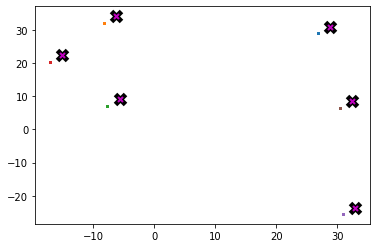

In [39]:
plot_data(centroids+2, X, n_samples)

## Animation

In [40]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [41]:
def do_one(d):
    if d: one_update(X)
    ax.clear() # dont print on top of last one
    plot_data(centroids+2, X, n_samples, ax=ax)

In [42]:
# create your own animation
X = data.clone()
fig,ax = plt.subplots()
ani = FuncAnimation(fig, do_one, frames=5, interval=500, repeat=False)
plt.close()
HTML(ani.to_jshtml())

## GPU batched algorithm

To truly accelerate the algorithm, we need to be performing updates on a batch of points per iteration, instead of just one as we were doing.

In [43]:
bs=5
X = data.clone()
x = X[:bs]
x.shape,X.shape

(torch.Size([5, 2]), torch.Size([1500, 2]))

In [45]:
# 1500 vs 5 -> not compatible
X-x

RuntimeError: The size of tensor a (1500) must match the size of tensor b (5) at non-singleton dimension 0

In [46]:
# 2 vs 2
# 1 vs 1500
# 5 vs 1
# all good
X[None].shape, x[:, None].shape

(torch.Size([1, 1500, 2]), torch.Size([5, 1, 2]))

In [48]:
# out aim is 5 x 1500
diff = X[None] - x[:, None]
print(diff.shape)
# sum over x and y dim=2
diff.square().sum(2).sqrt()


torch.Size([5, 1500, 2])


tensor([[ 0.000,  3.899,  4.834,  ..., 17.628, 22.610, 21.617],
        [ 3.899,  0.000,  4.978,  ..., 21.499, 26.508, 25.500],
        [ 4.834,  4.978,  0.000,  ..., 19.373, 24.757, 23.396],
        [ 3.726,  0.185,  4.969,  ..., 21.335, 26.336, 25.333],
        [ 6.273,  5.547,  1.615,  ..., 20.775, 26.201, 24.785]])

In [49]:
def dist_b(a,b): return (((a[None]-b[:,None])**2).sum(2)).sqrt()

In [51]:
dist_b(X, x)

tensor([[ 0.000,  3.899,  4.834,  ..., 17.628, 22.610, 21.617],
        [ 3.899,  0.000,  4.978,  ..., 21.499, 26.508, 25.500],
        [ 4.834,  4.978,  0.000,  ..., 19.373, 24.757, 23.396],
        [ 3.726,  0.185,  4.969,  ..., 21.335, 26.336, 25.333],
        [ 6.273,  5.547,  1.615,  ..., 20.775, 26.201, 24.785]])

In [52]:
dist_b(X, x).shape

torch.Size([5, 1500])

In [58]:
X[None,:].shape, x[:,None].shape, (X[None,:]-x[:,None]).shape

(torch.Size([1, 1500, 2]), torch.Size([5, 1, 2]), torch.Size([5, 1500, 2]))

In [55]:
gaussian??

Signature: gaussian(d, bw)
Docstring: <no docstring>
Source:    def gaussian(d, bw): return torch.exp(-0.5*((d/bw))**2) / (bw*math.sqrt(2*math.pi))
File:      /tmp/ipykernel_95/1178221795.py
Type:      function


In [59]:
weight = gaussian(dist_b(X, x), 2)
weight

tensor([[    0.199,     0.030,     0.011,  ...,     0.000,     0.000,     0.000],
        [    0.030,     0.199,     0.009,  ...,     0.000,     0.000,     0.000],
        [    0.011,     0.009,     0.199,  ...,     0.000,     0.000,     0.000],
        [    0.035,     0.199,     0.009,  ...,     0.000,     0.000,     0.000],
        [    0.001,     0.004,     0.144,  ...,     0.000,     0.000,     0.000]])

In [60]:
weight.shape,X.shape

(torch.Size([5, 1500]), torch.Size([1500, 2]))

In [63]:
# 2 vs 1 
# 1500 v 1500
# 1 vs 5
weight[...,None].shape, X[None].shape

(torch.Size([5, 1500, 1]), torch.Size([1, 1500, 2]))

In [70]:
# product and sum use einsum
num = (weight[...,None]*X[None]).sum(1)
num.shape

torch.Size([5, 2])

In [69]:
# i -> 5
# j -> 1500
# k - > 2

tensor([[367.870, 386.231],
        [518.332, 588.680],
        [329.665, 330.782],
        [527.617, 598.217],
        [231.302, 234.155]])

In [71]:
torch.einsum('ij,jk->ik', weight, X)

tensor([[367.870, 386.231],
        [518.332, 588.680],
        [329.665, 330.782],
        [527.617, 598.217],
        [231.302, 234.155]])

In [72]:
weight@X

tensor([[367.870, 386.231],
        [518.332, 588.680],
        [329.665, 330.782],
        [527.617, 598.217],
        [231.302, 234.155]])

In [73]:
div = weight.sum(1, keepdim=True)
div.shape

torch.Size([5, 1])

In [74]:
num/div

tensor([[26.376, 27.692],
        [26.101, 29.643],
        [28.892, 28.990],
        [26.071, 29.559],
        [29.323, 29.685]])

In [76]:
def meanshift(data, bs=500):
    n = len(data)
    X = data.clone()
    for it in range(5):
        for i in range(0, n, bs):
            s = slice(i, min(i+bs,n))
            weight = gaussian(dist_b(X, X[s]), 2.5)
#             weight = tri(dist_b(X, X[s]), 8)
            div = weight.sum(1, keepdim=True)
            X[s] = weight@X/div
    return X

Although each iteration still has to launch a new cuda kernel, there are now fewer iterations, and the acceleration from updating a batch of points more than makes up for it.

In [77]:
data = data.cuda()

In [78]:
X = meanshift(data).cpu()

In [79]:
%timeit -n 5 _=meanshift(data, 1250).cpu()

3.5 ms ± 559 µs per loop (mean ± std. dev. of 7 runs, 5 loops each)


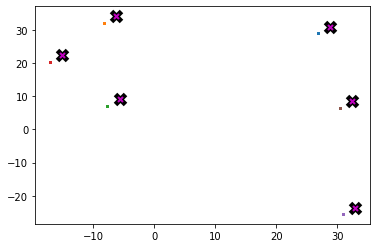

In [80]:
plot_data(centroids+2, X, n_samples)

**Homework:** implement k-means clustering, dbscan, locality sensitive hashing, or some other clustering, fast nearest neighbors, or similar algorithm of your choice, on the GPU. Check if your version is faster than a pure python or CPU version.

Bonus: Implement it in APL too!

Super bonus: Invent a new meanshift algorithm which picks only the closest points, to avoid quadratic time.

Super super bonus: Publish a paper that describes it :D

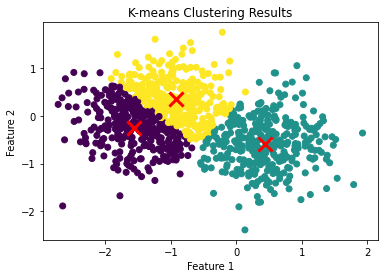

In [82]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Generate synthetic data
def generate_data(num_points, num_centers, std_dev):
    centers = np.random.randn(num_centers, 2)
    points = []
    for i in range(num_centers):
        cluster_points = np.random.randn(num_points // num_centers, 2) * std_dev + centers[i]
        points.append(cluster_points)
    return np.vstack(points)

# K-means implementation using TensorFlow
def kmeans_tf(X, k, max_iterations=100):
    # Convert to TensorFlow tensor
    X = tf.convert_to_tensor(X, dtype=tf.float32)
    
    # Randomly initialize centroids
    centroids = tf.random.shuffle(X)[:k]
    
    for _ in range(max_iterations):
        # Expand dimensions to use broadcasting
        expanded_X = tf.expand_dims(X, axis=1)
        expanded_centroids = tf.expand_dims(centroids, axis=0)
        
        # Compute distances between points and centroids
        distances = tf.reduce_sum(tf.square(expanded_X - expanded_centroids), axis=2)
        
        # Assign points to nearest centroid
        assignments = tf.argmin(distances, axis=1)
        
        # Update centroids
        new_centroids = []
        for i in range(k):
            mask = tf.equal(assignments, i)
            cluster_points = tf.boolean_mask(X, mask)
            new_centroid = tf.reduce_mean(cluster_points, axis=0)
            new_centroids.append(new_centroid)
        
        new_centroids = tf.stack(new_centroids)
        
        # Check for convergence
        if tf.reduce_all(tf.equal(centroids, new_centroids)):
            break
        
        centroids = new_centroids
    
    return centroids, assignments

# Main execution
if __name__ == "__main__":
    # Generate synthetic data
    num_points = 1000
    num_centers = 3
    std_dev = 0.5
    X = generate_data(num_points, num_centers, std_dev)
    
    # Run K-means
    k = 3
    centroids, assignments = kmeans_tf(X, k)
    
    # Convert results back to numpy for plotting
    X_np = X.copy()
    centroids_np = centroids.numpy()
    assignments_np = assignments.numpy()
    
    # Plot results
    plt.scatter(X_np[:, 0], X_np[:, 1], c=assignments_np, cmap='viridis')
    plt.scatter(centroids_np[:, 0], centroids_np[:, 1], c='red', marker='x', s=200, linewidths=3)
    plt.title('K-means Clustering Results')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()

## Homework

Attempt to implement kmeans

In [298]:
# new data
centroids = torch.rand(n_clusters, 2)*70-35
slices = [sample(c) for c in centroids]
data = torch.cat(slices)
data.shape

torch.Size([1500, 2])

In [299]:
X = data.clone()

In [300]:
X.shape, centroids.shape

(torch.Size([1500, 2]), torch.Size([6, 2]))

In [140]:
diff = X[:,None,:] - centroids[None, :, :]
# distance to each centroid
dist = diff.square().sum(2)
# nearest centroid
nearest = dist.argmin(1)

In [ ]:
dist.shape, nearest.shape, X.shape

(torch.Size([1500, 6]), torch.Size([1500]), torch.Size([1500, 2]))

In [178]:
nearest

tensor([0, 0, 0,  ..., 5, 5, 5])

In [277]:

nearest_oh = F.one_hot(nearest, n_clusters).float()


In [278]:

nearest_oh.shape, X.shape

(torch.Size([1500, 6]), torch.Size([1500, 2]))

In [279]:
sum_coords = nearest_oh.T@X
sum_coords

tensor([[-7437.489, -1001.083],
        [-2937.613, -1292.690],
        [ 6187.774, -5737.597],
        [-4565.938, -3602.226],
        [  571.617, -4784.160],
        [ 1774.312, -7450.224]])

In [280]:
nearest_oh.shape, X.shape

(torch.Size([1500, 6]), torch.Size([1500, 2]))

In [281]:
sum_coords1 = torch.einsum("ij,ik->jk",nearest_oh, X )

In [282]:
counts = nearest_oh.numpy().sum(0)

In [283]:
sum_coords.shape, counts.shape

(torch.Size([6, 2]), (6,))

In [284]:
new_centroids = sum_coords / counts[:,None]
new_centroids.numpy()

array([[-29.749956 ,  -4.004332 ],
       [-11.75045  ,  -5.1707597],
       [ 24.751097 , -22.950386 ],
       [-18.263754 , -14.408904 ],
       [  2.3049073, -19.290968 ],
       [  7.0409203, -29.564379 ]], dtype=float32)

In [297]:
torch.allclose(centroids, new_centroids, rtol=1e-3, atol=1e-3)

False

In [19]:
data, centroids

(tensor([[26.204, 26.349],
         [25.691, 30.213],
         [30.431, 28.693],
         ...,
         [30.772,  9.323],
         [29.354,  3.960],
         [31.168,  5.309]]),
 tensor([[ 26.759,  29.050],
         [ -8.200,  32.151],
         [ -7.669,   7.063],
         [-17.040,  20.555],
         [ 30.854, -25.677],
         [ 30.422,   6.551]]))

In [29]:
n_clusters=6
# middle of the clusters
centroids = torch.rand(n_clusters, 2)*70-35

In [30]:
centroids

tensor([[ -7.811, -21.110],
        [-15.157,   2.178],
        [ -6.221,  16.940],
        [-19.370,  -9.956],
        [-34.685,  28.569],
        [ -6.586, -27.591]])

In [31]:
def sample(m): return MultivariateNormal(m, torch.diag(tensor([5.,5.]))).sample((n_samples,))

In [32]:
slices = [sample(c) for c in centroids]
data = torch.cat(slices)
data.shape

torch.Size([1500, 2])

In [50]:
import torch.nn.functional as F
def kmeans(data, centroids, k):
    X = data.clone()
    # middle of the clusters
    while True:
        # distance to each centroid
        diff = X[:,None,:] - centroids[None, :, :]
        dist = diff.square().sum(2)
        # nearest centroid
        nearest = dist.argmin(1)
        # ohe to allow sum per nearest cluster
        nearest_oh = F.one_hot(nearest, n_clusters).float()
        # sum per points vs clusters 2 diff methos matmult and einsum
        # sum_coords = nearest_oh.T@X
        sum_coords = torch.einsum("ij,ik->jk",nearest_oh, X )
        counts = nearest_oh.sum(0)
        # calc num points
        new_centroids = sum_coords / counts[:,None]
        if torch.allclose(centroids, new_centroids, rtol=1e-5, atol=1e-8): return new_centroids
        centroids = new_centroids

In [51]:
centroids_new = kmeans(data, centroids, 6)

In [52]:
%timeit kmeans(data, centroids, 6)

806 µs ± 8.84 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [53]:
centroids

tensor([[ -7.811, -21.110],
        [-15.157,   2.178],
        [ -6.221,  16.940],
        [-19.370,  -9.956],
        [-34.685,  28.569],
        [ -6.586, -27.591]])

In [54]:
centroids_new

tensor([[ -7.802, -20.846],
        [-15.115,   2.087],
        [ -6.164,  17.192],
        [-19.397,  -9.812],
        [-34.632,  28.548],
        [ -6.580, -27.709]])